Optimización del Mantenimiento Predictivo en motores Turbo Fan Basado en Datos e Inteligencia Artificial.

INTRODUCCIÓN

En la era de la Industria 4.0, la integración de tecnologías avanzadas en el mantenimiento de equipos críticos ha revolucionado la forma en que se gestionan y operan los sistemas industriales. Uno de los campos que ha experimentado un notable avance es el mantenimiento predictivo de motores turbo fan, esenciales en la aviación y otras aplicaciones industriales. La optimización de este tipo de mantenimiento, basada en datos y potenciada por la inteligencia artificial (IA), ofrece una promesa significativa para mejorar la eficiencia operativa, reducir costos y aumentar la seguridad. La relevancia de esta optimización radica en su capacidad para transformar el mantenimiento tradicional en un proceso más eficiente, seguro y sostenible, impulsado por la inteligencia artificial y el análisis de datos. Esto no solo mejora el rendimiento y la fiabilidad de los motores turbo fan, sino que también aporta beneficios económicos y ambientales significativos.

DATASET

El NASA Turbofan Engine Degradation Simulation Dataset es un conjunto de datos utilizado comúnmente para problemas de predicción de la vida útil remanente (RUL) de motores. Contiene datos de simulaciones de la degradación de motores turbofan bajo condiciones de funcionamiento, con 4 subconjuntos etiquetados como FD001, FD002, FD003 y FD004, como se observa en la Fig 1.

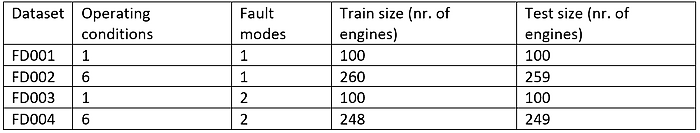

Fig. 1

Este conjunto de datos se generó con el simulador C-MAPSS. C-MAPSS significa 'Comercial Modular Aero-Propulsion System Simulation' y es una herramienta para la simulación de datos realistas de motores turbofan comerciales. Cada vuelo es una combinación de una serie de condiciones de vuelo con un período de transición lineal razonable para permitir que el motor cambie de una condición de vuelo a la siguiente. Las condiciones de vuelo están dispuestas para cubrir un ascenso típico desde el nivel del mar hasta 35K ft y descender de nuevo al nivel del mar. La falla se inyectó en un momento dado en uno de los vuelos y persiste durante todo el resto de los vuelos, aumentando efectivamente la edad del motor. La intención es identificar qué vuelo y cuándo en el vuelo se produjo la falla.

Cómo se conocía los datos: 

Los datos proporcionados proceden de una simulación de motor de alto nivel de fidelidad diseñada para simular la degradación nominal y del motor de falla a través de una serie de vuelos. Los datos simulados se crearon con una herramienta Matlab Simulink llamada C-MAPSS.

Tarifas y parámetros de muestreo 

Descripción: Los vuelos son grabaciones de vuelos completas de la muestra a 1 Hz y consisten en 30 parámetros de estado de motor y vuelo. Cada vuelo contiene 7 condiciones de vuelo únicas para un vuelo de aproximadamente 90 min que incluye ascenso a crucero a 35K y descenso de vuelta al nivel del mar. Los parámetros para cada vuelo son las condiciones de vuelo, los indicadores de salud, las temperaturas de medición y las mediciones de presión.

Fallas/Anomalies: 
Las fallas surgieron del ventilador del motor de entrada, el compresor de baja presión, el compresor de alta presión, la turbina de alta presión y la turbina de baja presión.

Para más detalles puede visitar [1], que es de donde se obtiene esta información.

Descripcion del Motor.

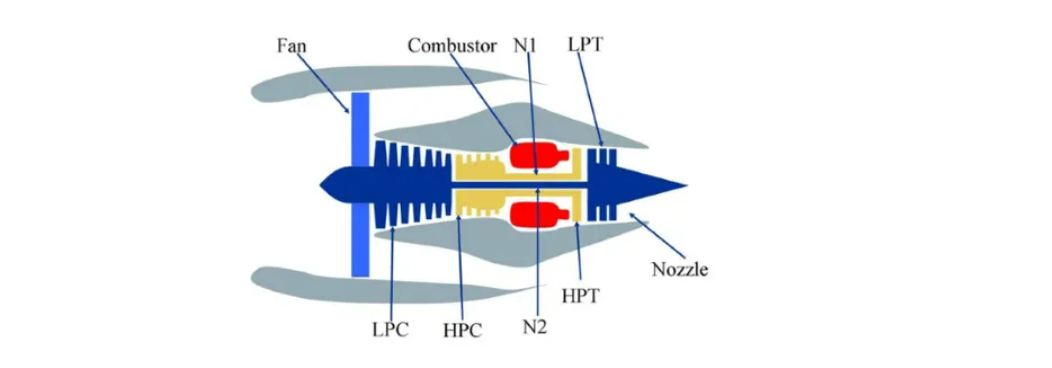

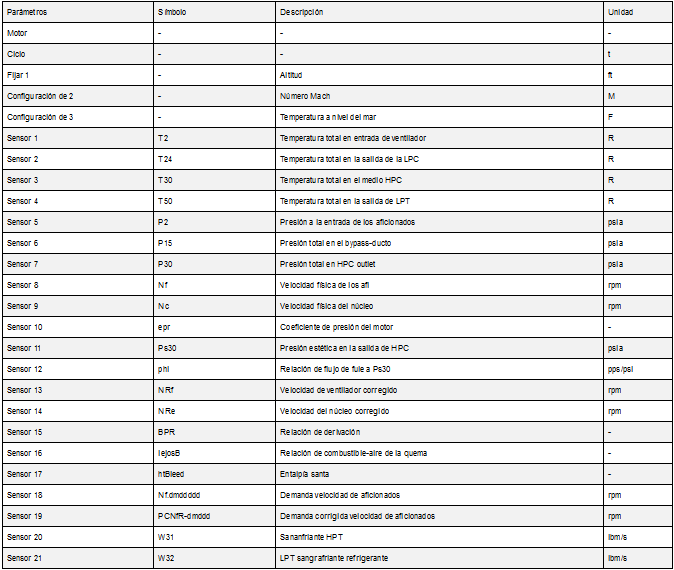


    LPC/HPS = Compresor de baja presión/a la alta presión
    LPT/HPT = Turbina de presión baja/a la alta presión


Este conjunto de datos consta de varios archivos que se agrupan ampliamente en 3 categorías: tren, prueba y RUL. Hay 4 conjuntos de datos disponibles de complejidad creciente. En este libro se trabajará con el conjunto de datos FD001 es el primero de la serie y el menos complejo.

Trayectorias de trenes: 100

Trayectorias de prueba: 100

Condiciones: UNO (nivel del mar)

Modos de falla: UNO (degradación de HPC)

DESARROLLO

Es primordial realizar un eda basico sin embargo lo mismo pra el set FD001, se detalla en [2]. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# define filepath to read data
dir_path = './CMaps/'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
def add_remaining_useful_life(df): 
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [4]:
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']#Sensors not taken into account for the evaluation
drop_labels = index_names+setting_names+drop_sensors

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

In [5]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

REGRESION LINEAL BASE

In [6]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:44.66819159545424, R2:0.5794486527796772
test set RMSE:31.95263302773947, R2:0.40877368076582765


Regresion Lineal Hyperparametros

In [7]:
X_trainreg2 = train.drop(drop_labels, axis=1)
y_trainreg2 = X_trainreg2.pop('RUL')

In [25]:
X_trainreg2.head()

,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


In [27]:
y_trainreg2

0        191
1        190
2        189
3        188
4        187
        ... 
20626      4
20627      3
20628      2
20629      1
20630      0
Name: RUL, Length: 20631, dtype: int64

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import RepeatedKFold, cross_val_score
import matplotlib.pyplot as plt
import numpy as np


In [13]:

# Configuración de validación cruzada
kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)


In [21]:

# Crear un diccionario de parámetros a probar
#param_grid = {'reg__alpha': np.logspace(-10, 3, 100)} # Rango de valores para alpha (parámetro de regularización)
param_grid = {'reg__alpha': np.logspace(-6, 6, 13)}


In [30]:

# Definir la pipeline
model = Pipeline([
    ('feature_selection', SelectKBest(score_func=mutual_info_classif, k=10)),
    ('poly', PolynomialFeatures(degree=2)), # Se fija el grado del polinomio en 75
    ('scal', StandardScaler()),
    ('pca', PCA(n_components=0.95)), #comprime: 95% variance retained (information retained)
    ('reg', Ridge()) # Se cambia a Ridge
])


In [ ]:

# Inicializar GridSearchCV
grid_search = GridSearchCV(model, param_grid,
                           cv=kfold, # kfold cross validation
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           verbose=4)

# Ajustar GridSearchCV al conjunto de entrenamiento
grid_search.fit(X_trainreg2, y_trainreg2)

# Obtener los resultados de la búsqueda de parámetros
results = grid_search.cv_results_

# Obtener el mejor modelo encontrado por GridSearchCV
# En un escenario práctico, este paso sería redundante porque 'GridSearchCV' ya ajusta el mejor modelo.
# Sin embargo, se incluye aquí con fines didácticos para demostrar cómo se realiza el ajuste de un modelo.
best_model = grid_search.best_estimator_

# Obtener los valores de alpha probados
alphas = param_grid['reg__alpha']
# Obtener el valor de alpha seleccionado por el mejor modelo
best_alpha = best_model.named_steps['reg'].alpha


Fitting 10 folds for each of 13 candidates, totalling 130 fits
[CV 1/10] END reg__alpha=1e-06;, score=(train=-2132.664, test=-2096.488) total time=  36.8s


In [ ]:
# Ajustar el mejor modelo al conjunto de entrenamiento
best_model.fit(X_trainreg2, y_trainreg2)

# Hacer predicciones con el mejor modelo
predictions = best_model.predict(test_df[['hour']])
y_hat_trainreg2 = lm.predict(X_trainreg2)
y_hat_testreg2 = lm.predict(X_test)

# Evaluar el rendimiento del modelo en el conjunto de prueba
#rmse_test, r2_test = calculate_regression_metrics(best_model, test_df[['hour']], test_df['users'])
#print("RMSE test (best model): ", rmse_test, 'active users')
#print("R-squared test (best model):", r2_test)
evaluate(y_train, y_hat_trainreg2, 'train')
evaluate(y_test, y_hat_testreg2)

In [ ]:

# Extraer los errores de entrenamiento y validación cruzada
train_errors = np.sqrt(-results['mean_train_score'])
val_errors = np.sqrt(-results['mean_test_score'])

# Graficar los errores de entrenamiento y validación cruzada
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_errors, label='Train Error', marker='o')
plt.plot(alphas, val_errors, label='Validation Error', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ (Regularization Parameter)')
plt.ylabel('Root Mean Squared Error')
plt.title('Training and Validation Error vs Alpha (Regularization Parameter)')

plt.grid(True)
# Dibujar una línea vertical en el valor de alpha seleccionado
plt.axvline(x=best_alpha, color='r', linestyle='--', label=f'Best model at $\lambda$: {best_alpha:.2e}')
plt.legend()
plt.show()


SVM Y AJUSTE DE HYPERPARAMETROS

REFERENCIAS

[1] NASA, “C-MAPSS Aircraft Engine Simulator Data,” *Data.gov*, 2018. [En línea]. Disponible: https://catalog.data.gov/dataset/c-mapss-aircraft-engine-simulator-data. [Accedido: 15-Nov-2024].

[2] K. Peters, “1_FD001_EDA+baseline.ipynb,” *GitHub*, 2020. [En línea]. Disponible: https://github.com/kpeters/exploring-nasas-turbofan-dataset/blob/master/1_FD001_EDA%2Bbaseline.ipynb. [Accedido: 15-Nov-2024].


CONCLUSIONES